# Feature Engineering and Selection

This notebook has two objectives:
1. To study and plot the correlations of the features that will be shown in the dashboard
2. To create the dataframe that will train our model

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

### Feature engineering and selection

In [44]:
pd.to_datetime(dfIT.index, format='%Y-%m-%d')

DatetimeIndex(['2008-01-01', '2008-02-01', '2008-03-01', '2008-04-01',
               '2008-05-01', '2008-06-01', '2008-07-01', '2008-08-01',
               '2008-09-01', '2008-10-01',
               ...
               '2023-05-01', '2023-06-01', '2023-07-01', '2023-08-01',
               '2023-09-01', '2023-10-01', '2023-11-01', '2023-12-01',
               '2024-01-01', '2024-02-01'],
              dtype='datetime64[ns]', name='date', length=194, freq=None)

In [45]:
dfIT.index

DatetimeIndex(['2008-01-01', '2008-02-01', '2008-03-01', '2008-04-01',
               '2008-05-01', '2008-06-01', '2008-07-01', '2008-08-01',
               '2008-09-01', '2008-10-01',
               ...
               '2023-05-01', '2023-06-01', '2023-07-01', '2023-08-01',
               '2023-09-01', '2023-10-01', '2023-11-01', '2023-12-01',
               '2024-01-01', '2024-02-01'],
              dtype='datetime64[ns]', name='date', length=194, freq=None)

,Electricity import (GWh),Electricity generated from natural gas GWh,Total electricity generated GWh,Fraction of electricity generated by gas,Gas consumed Mm3,Gas produced Mm3,Gas exported Mm3,Gas imported Mm3,Total Gas Stocks Mm3,Average Temperature (°C),Month,sinMonth,Gas imported last month Mm3,Gas consumed from stocks Mm3,Gas balance (???)
Electricity import (GWh),1.000000,-0.391193,0.162437,-0.224364,0.202914,-0.043389,-0.131768,0.191843,0.048461,0.023824,-0.029422,0.024593,0.168068,-0.030693,-0.024421
Electricity generated from natural gas GWh,-0.391193,1.000000,-0.207848,0.986632,0.046722,-0.811163,0.613934,-0.368519,0.028171,NaN,-0.043770,0.213361,-0.208255,-0.302294,-0.137215
Total electricity generated GWh,0.162437,-0.207848,1.000000,-0.190447,0.110240,0.269469,-0.153263,0.337556,0.233935,0.342456,0.093096,-0.300668,0.199523,0.022594,-0.024390
Fraction of electricity generated by gas,-0.224364,0.986632,-0.190447,1.000000,0.162103,-0.267965,0.379851,-0.118320,0.117548,-0.231885,0.064303,0.229928,-0.038544,-0.270217,-0.182204
Gas consumed Mm3,0.202914,0.046722,0.110240,0.162103,1.000000,0.044897,-0.038019,0.243654,-0.298842,-0.884956,-0.172957,0.877690,0.048760,-0.870914,-0.858324
Gas produced Mm3,-0.043389,-0.811163,0.269469,-0.267965,0.044897,1.000000,-0.547118,-0.307448,-0.062198,-0.201673,0.003026,0.051341,-0.361340,-0.048709,-0.091032
Gas exported Mm3,-0.131768,0.613934,-0.153263,0.379851,-0.038019,-0.547118,1.000000,0.148908,0.089028,-0.418706,0.144394,0.028599,0.124975,-0.017701,0.025446
Gas imported Mm3,0.191843,-0.368519,0.337556,-0.118320,0.243654,-0.307448,0.148908,1.000000,-0.237925,-0.077955,-0.094649,-0.011062,0.580288,0.074559,0.069420
Total Gas Stocks Mm3,0.048461,0.028171,0.233935,0.117548,-0.298842,-0.062198,0.089028,-0.237925,1.000000,0.475952,0.717392,-0.356617,-0.185388,0.252721,0.247076
Average Temperature (°C),0.023824,NaN,0.342456,-0.231885,-0.884956,-0.201673,-0.418706,-0.077955,0.475952,1.000000,0.281874,-0.972265,0.129403,0.887782,0.887787


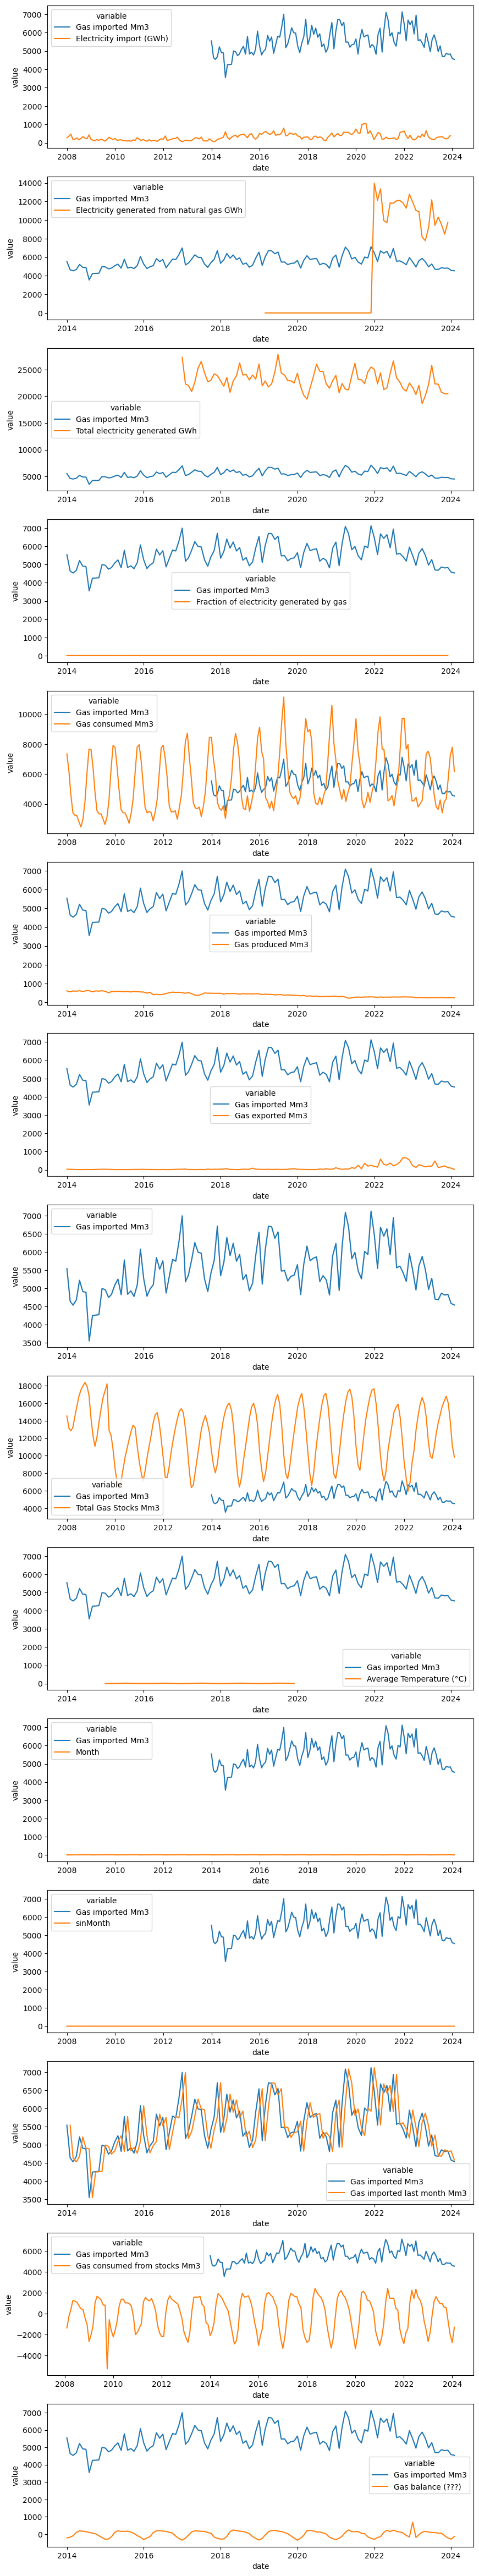

In [46]:
dfIT = pd.read_csv('Data_03.csv')
dfIT=dfIT.set_index('date')
dfIT.index=pd.to_datetime(dfIT.index, format='%Y-%m-%d')
#Extracting features
dfIT['Month'] = dfIT.index.month
dfIT['sinMonth'] = 1 + np.sin((dfIT['Month']+2)/6*np.pi) #January is numerically close to December

#Shifting features
dfIT['Gas imported last month Mm3'] = dfIT['Gas imported Mm3'].shift(1) # Gas imported the last month

#Balances features
dfIT['Gas consumed from stocks Mm3'] = dfIT['Total Gas Stocks Mm3'] - dfIT['Total Gas Stocks Mm3'].shift(1)
dfIT['Gas balance (???)'] = dfIT['Gas imported Mm3'] - dfIT['Gas exported Mm3'] + dfIT['Gas produced Mm3'] - dfIT['Gas consumed Mm3'] - dfIT['Gas consumed from stocks Mm3']

#Plotting normalized data
dfITn = dfIT.copy(deep=True)
'''
for column in dfITn.columns: #what I do here is put all values on a scale from 0 to 1, where 0 corresponds to min value and 1 to max value
    dfITn.loc[:,column] = (dfITn.loc[:,column] - dfITn.loc[:,column].min())/(dfITn.loc[:,column].max() - dfITn.loc[:,column].min())
'''
dfITn = dfITn.reset_index()

fig, axes = plt.subplots(len(dfITn.columns)-1,1,figsize = (10,60))

j = 1
for i in range(0,len(dfITn.columns)-1):
    sb.lineplot(x='date', y='value', hue='variable',data = pd.melt(dfITn[['date','Gas imported Mm3',dfITn.columns[j]]], ['date']), ax=axes[i])
    j = j + 1

dfITn = dfITn.set_index('date')

#let's see for only the non-NaN values
#display(dfITn.loc[slice(None, pd.to_datetime("2020-02",format='%Y-%m')), :].corr())
display(dfITn.corr())


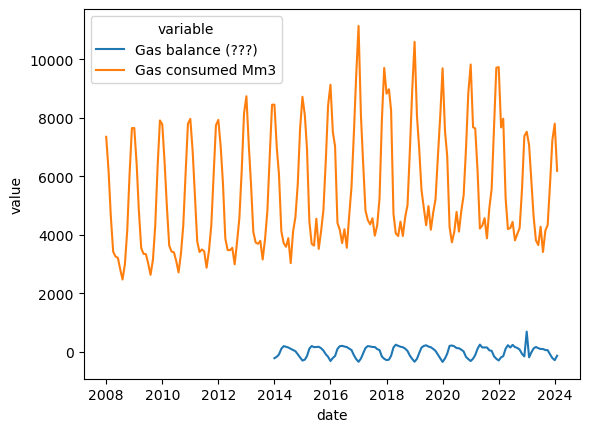

In [47]:
#dfIT.index = dfIT.index.strftime('%Y-%m-%d')
dfIT = dfIT.reset_index()

sb.lineplot(x='date', y='value', hue='variable', data = pd.melt(dfIT[['date','Gas balance (???)','Gas consumed Mm3']], ['date']))
#sb.lineplot(x='date', y='value', hue='variable', data = pd.melt(dfIT[['date','Total Gas Stocks Mm3','Gas consumed Mm3']], ['date']))
#sb.lineplot(x='date', y='value', hue='variable', data = pd.melt(dfIT[['date','Gas import - Gas export Mm3','Gas consumed Mm3']], ['date']))
#sb.lineplot(x='date', y='value', hue='variable', data = pd.melt(dfITn[['date','sinMonth','Gas consumed Mm3']], ['date']))
#sb.lineplot(x='date', y='value', hue='variable', data = pd.melt(dfITn[['date','Gas consumed Mm3','Total Gas Stocks Mm3']], ['date']))

dfIT = dfIT.set_index('date')

In [48]:
dfITn = dfITn.reset_index()
display(dfITn)
sb.lineplot(x='date', y='value', hue='variable',data = pd.melt(dfITn[['date','Gas imported Mm3',dfITn.columns[j]]], ['date']))
dfITn = dfITn.set_index('date')

,date,Electricity import (GWh),Electricity generated from natural gas GWh,Total electricity generated GWh,Fraction of electricity generated by gas,Gas consumed Mm3,Gas produced Mm3,Gas exported Mm3,Gas imported Mm3,Total Gas Stocks Mm3,Average Temperature (°C),Month,sinMonth,Gas imported last month Mm3,Gas consumed from stocks Mm3,Gas balance (???)
0,2008-01-01,275.0,NaN,NaN,NaN,7349.903293,NaN,NaN,NaN,14536.047619,NaN,1,2.000000,NaN,NaN,NaN
1,2008-02-01,365.0,NaN,NaN,NaN,6187.250915,NaN,NaN,NaN,13159.928571,NaN,2,1.866025,NaN,-1376.119048,NaN
2,2008-03-01,473.0,NaN,NaN,NaN,4644.642362,NaN,NaN,NaN,12846.952381,NaN,3,1.500000,NaN,-312.976190,NaN
3,2008-04-01,185.0,NaN,NaN,NaN,3422.614249,NaN,NaN,NaN,13234.309524,NaN,4,1.000000,NaN,387.357143,NaN
4,2008-05-01,194.0,NaN,NaN,NaN,3259.896578,NaN,NaN,NaN,14483.452381,NaN,5,0.500000,NaN,1249.142857,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189,2023-10-01,211.0,9532.0,20770.0,0.458931,4335.000000,253.0,162.0,4865.0,16807.542857,NaN,10,1.000000,4687.0,563.335714,57.664286
190,2023-11-01,266.0,8484.0,20469.0,0.414480,5744.000000,240.0,211.0,4814.0,15990.207143,NaN,11,1.500000,4865.0,-817.335714,-83.664286
191,2023-12-01,402.0,9749.0,20483.0,0.475956,7235.000000,240.0,117.0,4836.0,13925.550000,NaN,12,1.866025,4814.0,-2064.657143,-211.342857
192,2024-01-01,NaN,NaN,NaN,NaN,7799.000000,250.0,90.0,4583.0,11153.321429,NaN,1,2.000000,4836.0,-2772.228571,-283.771429


IndexError: index 16 is out of bounds for axis 0 with size 16